#  Прогнозирование заказов такси

## Обзор данных и ресемплинг

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings 
warnings.filterwarnings('ignore') #скроем предупреждения

In [2]:
# чтение файла `taxi.csv` и сохранение в переменной `df`
# запишем сразу даты в качесте индексов и в формате `datetime64`
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sample(5) # просмотр 5 строк таблицы `df`

,num_orders
datetime,
2018-06-03 00:50:00,23
2018-06-03 13:40:00,17
2018-05-22 00:30:00,18
2018-07-04 02:20:00,19
2018-03-27 15:30:00,8


In [4]:
df.info() #получение общей информации о таблице `df`

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В таблице 1 столбец. Тип данных в столбце: int64.

Согласно документации к данным:
* `num_orders` — количество заказов такси.

Целевой признак - `num_orders`.

Названия столбца соответствует хорошему стилю.

Пропущенных значений нет.

Данные представляют собой временной ряд. Согласно цели исследования горизонтом прогнозирования - 1 час. Исходя из этого необходимо провести ресемплирование данных по одному часу.

In [5]:
# отсортируем данные по индексу
df.sort_index(inplace=True)

# ресемплируем данные по одному часу и возьмём среднее значение
df = df.resample('1H').sum()

df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


### Выводы

В каждой строке таблицы данные о количестве заказов такси в аэропортах в определённое время и дату. 

Предварительно можно утверждать, что, данных достаточно для выбора модели. Пропусков в данных не обнаружено, название столбца соответствует хорошему стилю.

Проведён ресемплинг данных по одному часу в соответствие с посталенной целью исследования.

Чтобы двигаться дальше, нужно проанализировать данные.

## Анализ данных

Построим график нашего временного ряда.

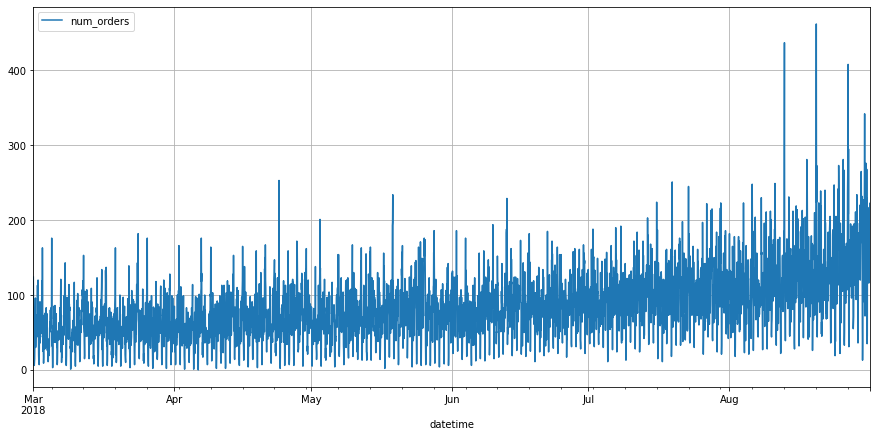

In [7]:
df.plot(grid=True, figsize=(15,7));

Попробуем сгладить данные по дням, по неделям и месяцам. Напишем для этого функцию plotMovingAverage.

In [8]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(series[n:], label="Actual values")
    plt.plot(rolling_mean, "r", label="Rolling mean trend")
    plt.legend(loc="upper left")
    plt.grid(True)

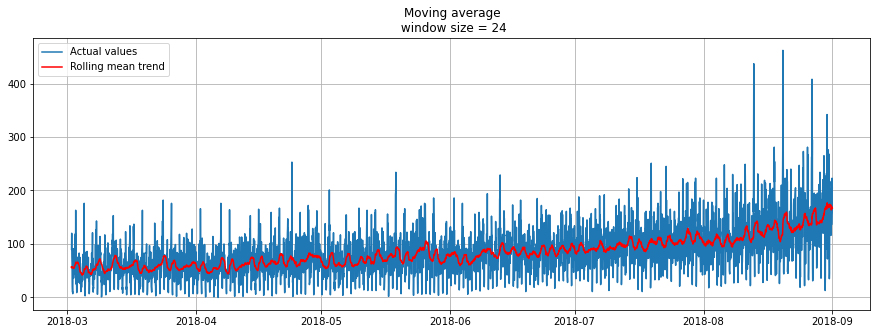

In [9]:
plotMovingAverage(df, 24) # сглаживаем по дням

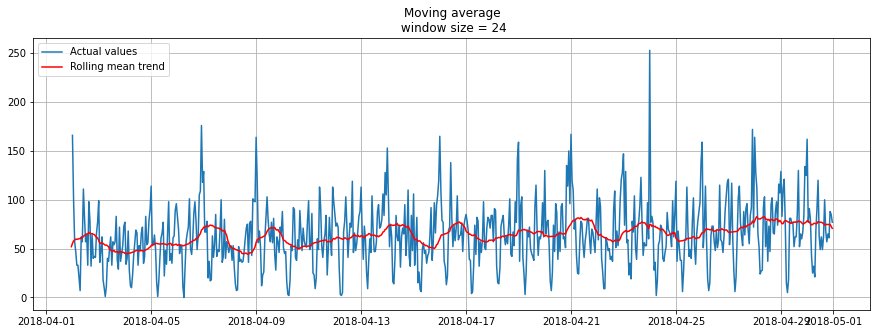

In [10]:
plotMovingAverage(df['2018-04-01':'2018-04-30'], 24) # сглаживаем по дням

Становится лучше видна динамика заказов такси - есть пики ближе к выходным.

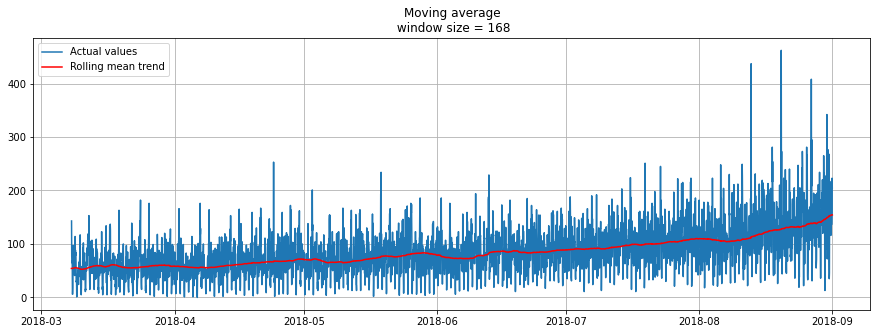

In [11]:
plotMovingAverage(df, 24*7) # сглаживаем по неделям

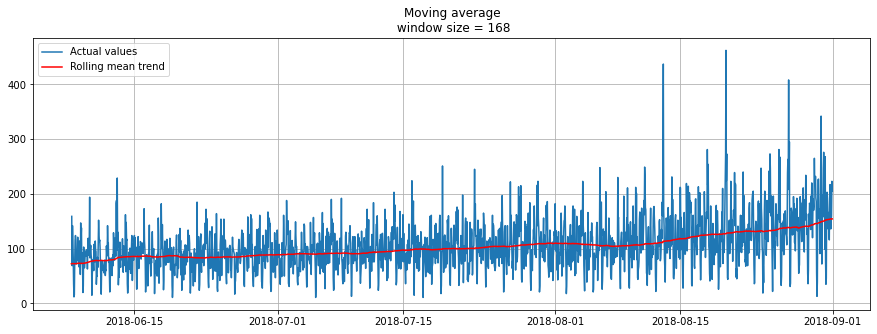

In [12]:
plotMovingAverage(df['2018-06-01':'2018-08-31'], 24*7) # сглаживаем по неделям

Недельное сглаживание отражает общие изменения, связанные с постепенным ростом числа заказов такси к сентябрю.

По графику видим, что скользящее среднее и стандартное отклонение со временем изменяются. Построим графики по тренду и сезенности.

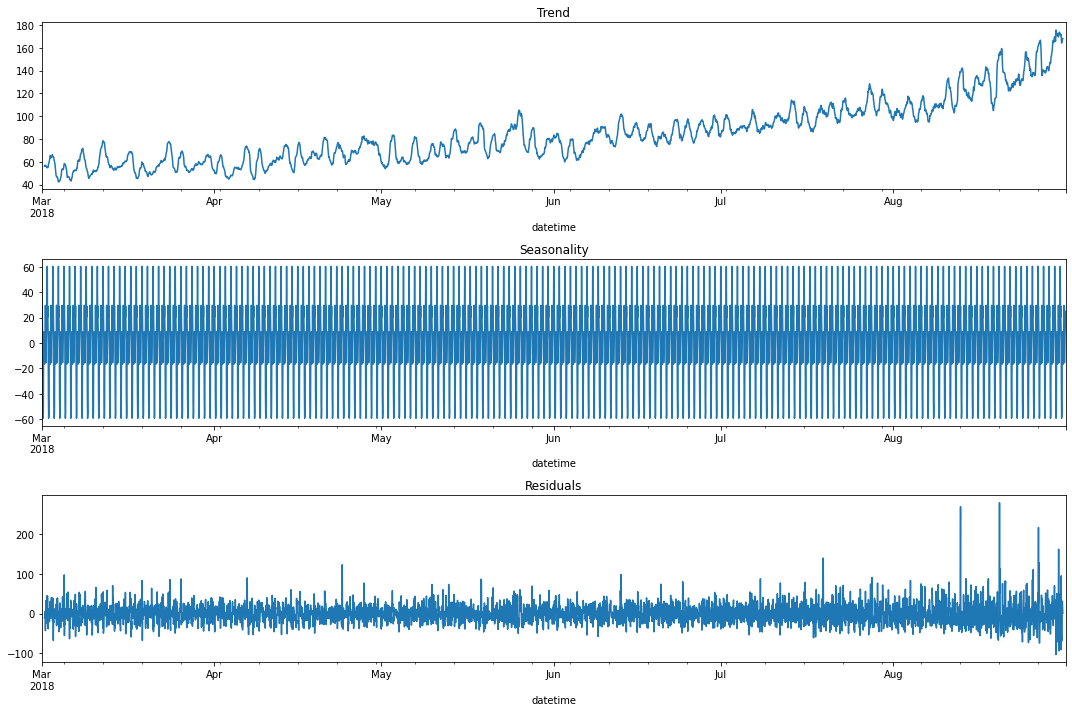

In [13]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим, что тренд восходящий, по графику сезонности по месяцам не просматривается какой-то динамики, посмотрим отедельно сезонность и тренды по дням недели и часам.

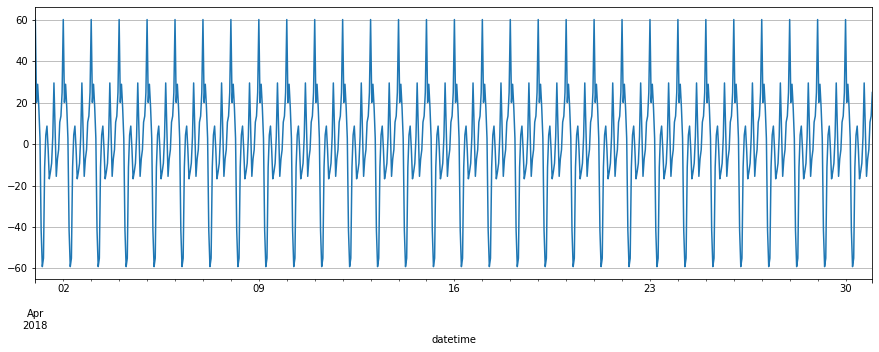

In [14]:
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(grid=True, figsize=(15,5));

В апреле 2018 года выходные дни это 1, 7-8, 14-15, 21-22 и 28-29, по графику сезонности также не видно какой-то динамики.

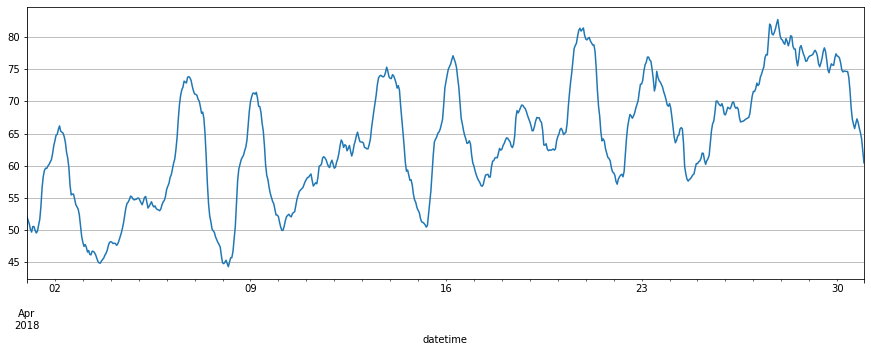

In [15]:
decomposed.trend['2018-04-01':'2018-04-30'].plot(grid=True, figsize=(15,5));

По графику тренда видно, что в понедельники и субботы количество заказов такси болше, чем в другие дни на постоянной основе.

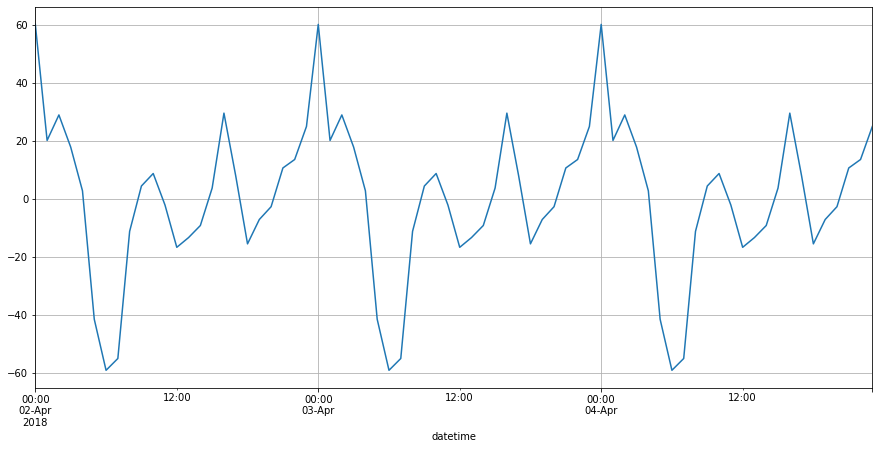

In [16]:
# смотрим сезонность по часам
decomposed.seasonal['2018-04-02':'2018-04-04'].plot(grid=True, figsize=(15,7));

Пик заказов в районе 0 часов, к утру количество заказов уменьшается.

Проверим ряд на стационарность, проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

In [17]:
test = sm.tsa.adfuller(df)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.0689242890279327
p-value:  0.028940051402614794
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


### Выводы

На данном этапе мы проанализировали данные. Разложили временной ряд по тренду и сезонности, по графикам видно, что:
- годовую сезонность и тренд мы не можем оценить, так как данные у нас только за полгода;
- у нас ярко выраженный месячный тренд;
- день месяца не влияет на сезонность и тренд;
- по дням недели видно, что в понедельники и субботы количество заказов такси болше, чем в другие дни на постоянной основе;
- по часам в сутках также видим, что к утру количество заказов падает.

Проверили ряд на стационарность тестом Дикки-Фуллера - ряд стационарный.

## Обучение разных моделей

### Константная модель

Для начала спрогнозируем временной ряд без обучения - так как нам нужно оценивать метрику RMSE, то новое значение x(t) спрогнозирем предыдущим значением ряда, то есть x(t-1). Разделим датасет на обучающую и тестовую выборки - тестовая выборка будет размером 10% от исходных данных (по условиям задачи).

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print("Среднее количество заказов такси в час:", test['num_orders'].mean())

pred_previous = test.shift(fill_value=0)
pred_previous.iloc[0] = train.iloc[-1]

print("RMSE:", mean_squared_error(test, pred_previous)**0.5)

Среднее количество заказов такси в час: 139.55656108597285
RMSE: 58.856486242815066


**Выводы**

RMSE константной модели 58.9, по условию задачи - значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Создание признаков

In [19]:
# создадим копию датасета для добавления в него признаков
df_with_features = df.copy()
df_with_features.sample(5)

,num_orders
datetime,
2018-04-01 15:00:00,50
2018-04-29 15:00:00,85
2018-07-29 02:00:00,136
2018-03-01 12:00:00,30
2018-08-24 04:00:00,93


Напишем функцию для создания признаков.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month # признак, в котором хранится месяц как число
    data['dayofweek'] = data.index.dayofweek # признак, в котором хранится день недели как число
    data['hour'] = data.index.hour # признак, в котором хранится час суток как число
    
    # признаки, в котором хранятся отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) 

    # признак, в котором хранится скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df_with_features, 24*7, 24)
df_with_features.head(5)

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


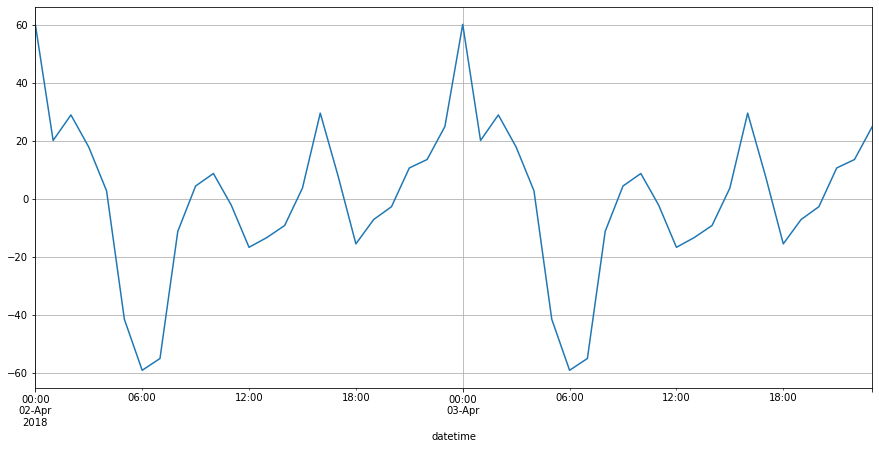

In [21]:
# смотрим сезонность по часам
decomposed.seasonal['2018-04-02':'2018-04-03'].plot(grid=True, figsize=(15,7));

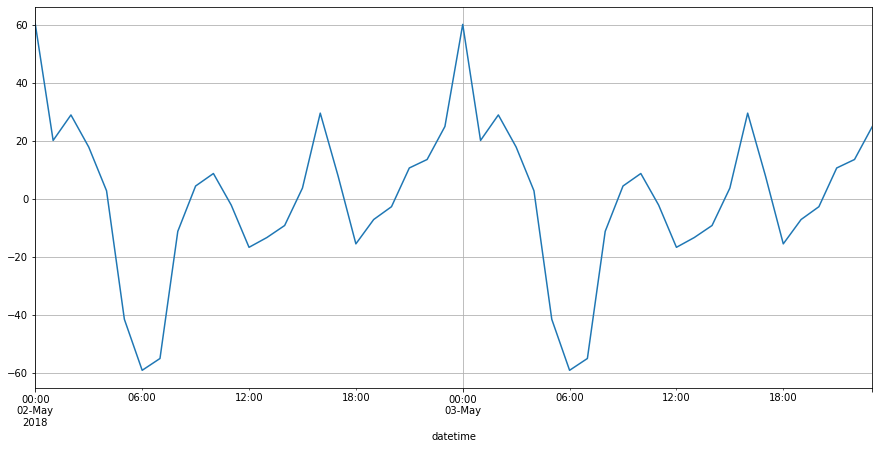

In [22]:
# смотрим сезонность по часам
decomposed.seasonal['2018-05-02':'2018-05-03'].plot(grid=True, figsize=(15,7));

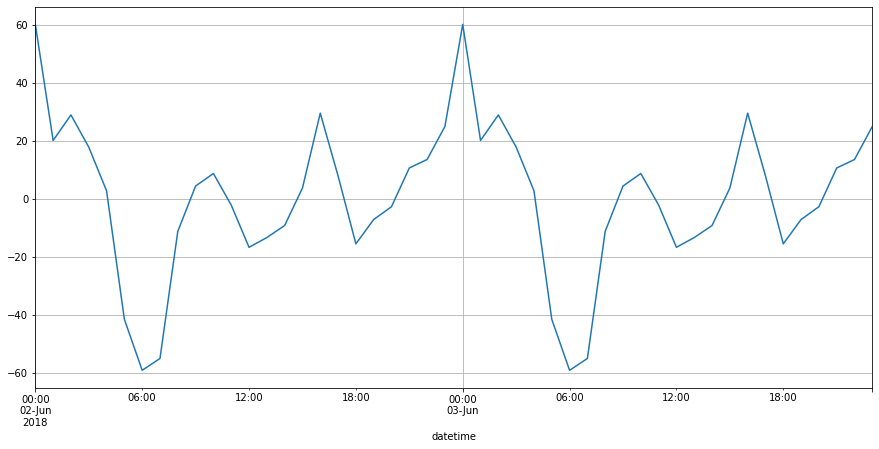

In [23]:
# смотрим сезонность по часам
decomposed.seasonal['2018-06-02':'2018-06-03'].plot(grid=True, figsize=(15,7));

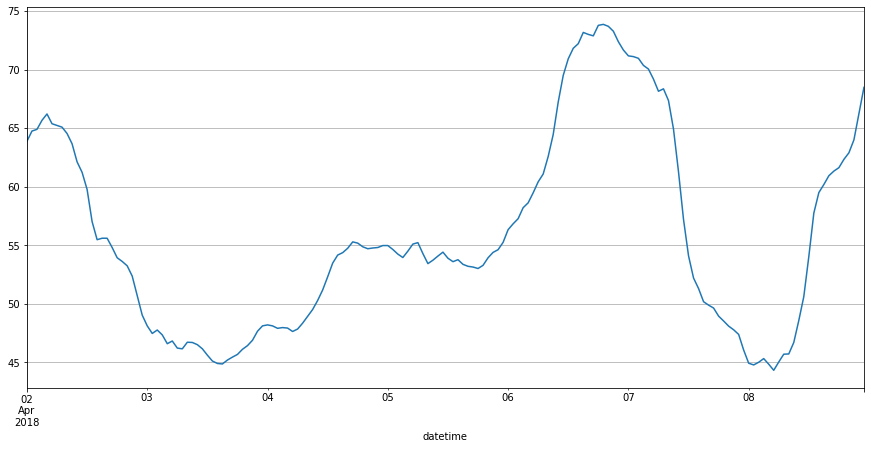

In [24]:
# смотрим сезонность по неделям
decomposed.trend['2018-04-02':'2018-04-08'].plot(grid=True, figsize=(15,7));

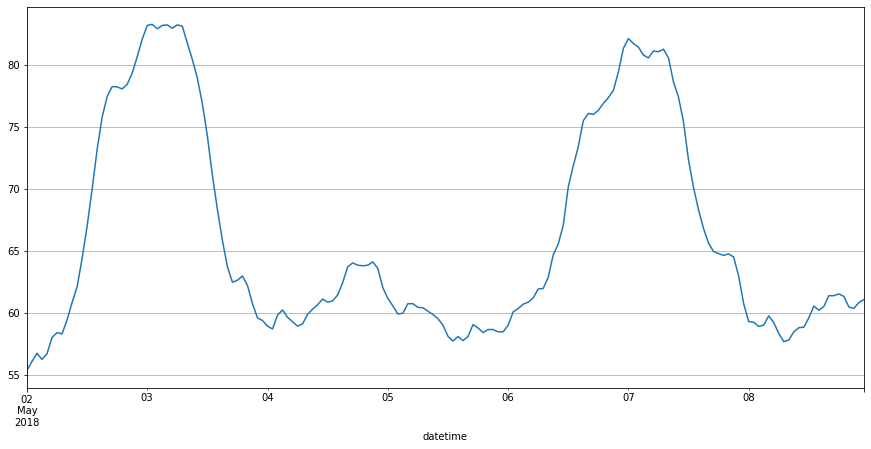

In [25]:
# смотрим сезонность по неделям
decomposed.trend['2018-05-02':'2018-05-08'].plot(grid=True, figsize=(15,7));

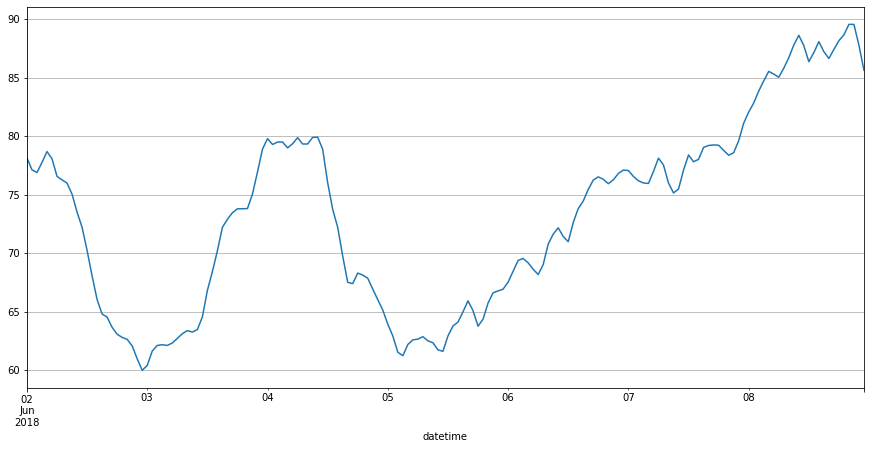

In [26]:
# смотрим сезонность по неделям
decomposed.trend['2018-06-02':'2018-06-08'].plot(grid=True, figsize=(15,7));

In [27]:
# удалим строки с пропусками
df_with_features = df_with_features.dropna()

In [28]:
# разделим таблицу с признаками на обучающую и тестовую выборки в соотношении 9:1.
features_train, features_test, target_train, target_test = train_test_split(
    df_with_features.drop('num_orders', axis=1), df_with_features.num_orders, shuffle=False, test_size=0.1)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3823, 172)
(425, 172)
(3823,)
(425,)


**Выводы**

Мы добавили в таблицу календарные признаки, признаки с отстающими значениями и признак со скользящим средним. Также мы разделили новую таблицу на обучающую, валидационную и тестовую выборки.

### Дерево решений в регрессии 

Подберём значения гиперпараметров для модели Дерево решений в регрессии, обучим её и оценитм качество.

In [29]:
clf = DecisionTreeRegressor(random_state=42)

parametrs = { 'max_depth': range (1, 6),
              'min_samples_leaf': range (1, 10) }

grid = GridSearchCV(clf, parametrs, cv=TimeSeriesSplit(n_splits = 3), n_jobs = 1, verbose = 0, return_train_score=True)
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 9}

Максимальная глубина дерева = 4, мнимальное количество листьев = 9. Применим полученные значения гиперпараметров и замерим метрику RMSE и время работы модели.

In [30]:
%%time

model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=9, random_state=42)
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

# получим предсказания модели на обучающей выборке и посчитаем значение метрики RMSE 
pred_train = model.predict(features_train)
rmse_train = mean_squared_error(target_train, pred_train)**0.5
    
print(f'RMSE модели на обучающей выборке: {rmse_train}')

RMSE модели на обучающей выборке: 22.920048574138093
CPU times: user 164 ms, sys: 4.22 ms, total: 168 ms
Wall time: 195 ms


**Выводы**

RMSE на обучающей выборке 22.9, что удовлетворяет условию задачи (значение метрики RMSE должно быть не больше 48) и лучше, чем на константной модели (58.9), время работы модели = 195 ms.

### Линейная регрессия

Подберём значения гиперпараметров для модели Линейная регрессия, обучим её и оценитм качество.

In [31]:
clf = LinearRegression()

parametrs = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(clf, parametrs, cv=TimeSeriesSplit(n_splits = 3), n_jobs = 1, verbose = 0, return_train_score=True)
grid.fit(features_train, target_train)

grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

copy_X и fit_intercept получилось значение по умолчанию, значение normalize необходимо учесть при работе с моделью. Применим полученные значения гиперпараметров и замерим метрику RMSE и время работы модели.

In [32]:
%%time

model = LinearRegression(normalize=True)
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

# получим предсказания модели на обучающей выборке и посчитаем значение метрики RMSE 
pred_train = model.predict(features_train)
rmse_train = mean_squared_error(target_train, pred_train)**0.5
    
print(f'RMSE модели на обучающей выборке: {rmse_train}')

RMSE модели на обучающей выборке: 20.47843074220986
CPU times: user 85.1 ms, sys: 5.65 ms, total: 90.7 ms
Wall time: 86.4 ms


**Выводы**

RMSE на обучающей выборке 20.5, что удовлетворяет условию задачи (значение метрики RMSE должно быть не больше 48) и лучше, чем на константной модели (58.9), время работы модели = 86.4 ms.

### LGBMRegressor

Подберём значения гиперпараметров для модели LGBMRegressor, обучим её и оценитм качество.

In [33]:
%%time

booster = lgb.LGBMRegressor(objective="regression", n_estimators=100, random_state=42, n_jobs=1, shuffle=False)

booster.fit(features_train, target_train, 
            eval_set=[(features_test, target_test)], 
            eval_metric="rmse")

[LightGBM] [Warning] Unknown parameter: shuffle
[1]	valid_0's rmse: 79.3041	valid_0's l2: 6289.15
[2]	valid_0's rmse: 74.7247	valid_0's l2: 5583.78
[3]	valid_0's rmse: 70.7456	valid_0's l2: 5004.94
[4]	valid_0's rmse: 67.1344	valid_0's l2: 4507.03
[5]	valid_0's rmse: 64.0277	valid_0's l2: 4099.54
[6]	valid_0's rmse: 60.9658	valid_0's l2: 3716.83
[7]	valid_0's rmse: 58.6485	valid_0's l2: 3439.65
[8]	valid_0's rmse: 56.2232	valid_0's l2: 3161.05
[9]	valid_0's rmse: 54.4411	valid_0's l2: 2963.84
[10]	valid_0's rmse: 52.6089	valid_0's l2: 2767.69
[11]	valid_0's rmse: 51.0367	valid_0's l2: 2604.74
[12]	valid_0's rmse: 49.4762	valid_0's l2: 2447.89
[13]	valid_0's rmse: 48.035	valid_0's l2: 2307.36
[14]	valid_0's rmse: 46.8634	valid_0's l2: 2196.18
[15]	valid_0's rmse: 45.9184	valid_0's l2: 2108.5
[16]	valid_0's rmse: 44.9234	valid_0's l2: 2018.12
[17]	valid_0's rmse: 43.896	valid_0's l2: 1926.86
[18]	valid_0's rmse: 43.1649	valid_0's l2: 1863.21
[19]	valid_0's rmse: 42.4924	valid_0's l2: 180

LGBMRegressor(n_jobs=1, objective='regression', random_state=42, shuffle=False)

In [34]:
# получим предсказания модели на обучающей выборке и посчитаем значение метрики RMSE 
pred_train = booster.predict(features_train)
rmse_train = mean_squared_error(target_train, pred_train)**0.5
    
print(f'RMSE модели на обучающей выборке: {rmse_train}')

RMSE модели на обучающей выборке: 9.157187580542567


**Выводы**

При значениие количества итераций = 100, RMSE на тестовой выборке 37, на обучающей - 9.16, что удовлетворяет условию задачи (значение метрики RMSE должно быть не больше 48) и лучше, чем на константной модели (58.9), время работы модели = 1.7 s, модель сильно переобучилась.

In [35]:
# составим таблицу сравнения полученных метрик
final = pd.DataFrame({'model': ['Constant', 'DecisionTreeR', 'LinearRegression', 'LGBMRegressor'], 
                      'RMSE': [58.9, 22.9, 20.5, 9.16],
                      'time': ['-', '195 ms', '86.4 ms', '1.7 s']})
final

,model,RMSE,time
0,Constant,58.90,-
1,DecisionTreeR,22.90,195 ms
2,LinearRegression,20.50,86.4 ms
3,LGBMRegressor,9.16,1.7 s


### Выводы

На данном этапе мы создали признаки для временного ряда, обучили несколько моделей и рассчитали метрику RMSE. По итогам проделанной работы наилучшее значение метрики для обучающей выборки у моделей LGBMRegressor = 9.16, при этом время у модели LinearRegression намного лучше = 188 ms, проверим на этапе Тестерование моделей обе эти модели на тестовой выборке.

## Тестирование модели

Значение метрики RMSE модели LGBMRegressor на тестовой выборке уже есть в рассчёте на предыдущем этапе = 37. Посмотрим на графике значения таргета и прогноза.

RMSE модели на тестовой выборке: 37.00248709958599


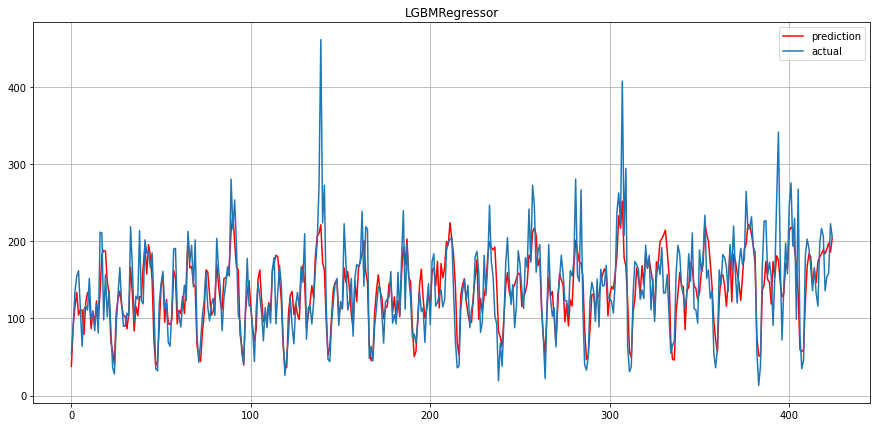

In [36]:
# получим предсказания модели на обучающей выборке и посчитаем значение метрики RMSE 
pred_test = booster.predict(features_test)
rmse_test = mean_squared_error(target_test, pred_test)**0.5
print(f'RMSE модели на тестовой выборке: {rmse_test}')

plt.figure(figsize=(15, 7))
plt.plot(pred_test, "r", label="prediction")
plt.plot(target_test.values, label="actual")
plt.legend()
plt.title("LGBMRegressor")
plt.grid(True);

Проверим RMSE модели LinearRegression на тестовой выборке и также построим график таргета и прогноза.

RMSE модели на тестовой выборке: 34.35044266537935
CPU times: user 93.9 ms, sys: 7.13 ms, total: 101 ms
Wall time: 119 ms


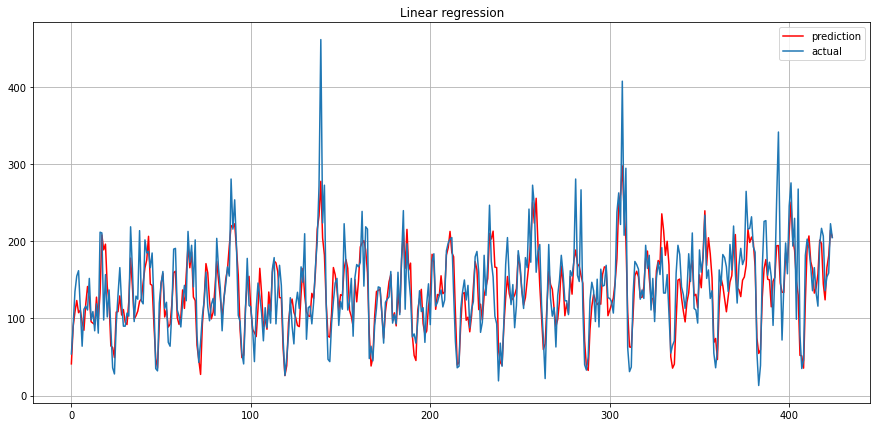

In [37]:
%%time

model = LinearRegression(normalize=True)
model.fit(features_train, target_train) # обучим модель на тренировочной выборке

# получим предсказания модели на тестовой выборке и посчитаем значение метрики RMSE 
pred_test = model.predict(features_test)
rmse_test = mean_squared_error(target_test, pred_test)**0.5
    
print(f'RMSE модели на тестовой выборке: {rmse_test}')

plt.figure(figsize=(15, 7))
plt.plot(pred_test, "r", label="prediction")
plt.plot(target_test.values, label="actual")
plt.legend()
plt.title("Linear regression")
plt.grid(True);

RMSE модели LinearRegression на тестовой выборке = 34.4 получилось лучше, чем у модели LGBMRegressor. По графикам значений таргета и прогноза также видно, что предсказания модели LinearRegression ближе к таргету, чем у модели LGBMRegressor.

### Выводы

По итогам тестирования моделей лучшей для решения задачи предсказания количества заказов такси является Линейная регрессия, RMSE на тестовой выборке = 34.4.

## Общий вывод

Исследование проводилось в четыре этапа:

* На этапе Обзор данных и ресемплинг мы ознакомились с данными в предоставленной таблице и зафиксировали, что предварительно данных для проведения исследования достаточно, а также произвели ресемплинг к одному часу;
* На этапе Анализ данных мы обнаружили в данных выбросы и удалили их, посмотрели тренд и сезонность и распределение среднего количества заказов по часам и дням недели;
* На этапе Обучение моделей мы рассчитали RMSE на константной модели, подготовили признаки для моделей, разделили выборку на обучающую, валидационную и тестовую, обучили модели Линейная регрессия, Дерево решений в регрессии, Случайный лес в регрессии и LGBMRegressor, попробовали различные гиперпараметры для них и рассчитали метрику RMSE, лучшее значение на обучающей выборке у модели LGBMRegressor = 9,16, при этом данная модель сильно переобучилась, а время её работы уступает модели Линейная регрессия;
* На этапе Тестирование моделей мы зафиксировали, что модель LGBMRegressor переобучилась, RMSE на тестовой выборке = 37; при этом RMSE Линейной регресси на тестовой выборке лучше, чем у LGBMRegressor = 34.4, модель также переобучилась, но не так сильно как LGBMRegressor. RMSE константной модели = 58.9, обе модели показывают лучшие значения метрики в сравнении с ней.

Исходя из полученных результатов наилучшей моделью для прогнозирования количества заказов такси в аэропортах на следующий час является Линейная регрессия.